## Data Processing for 1 min Chunked dataset

- normalize & run t-tests on train data
- select features with p-value < 0.05
- use top features to get train/test sets for models
- run baseline models
- hyperparameter tuning
- model comparison

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# import sklearn modules 

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import PowerTransformer

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
# get 1 min chunked dataset from Github 

url = 'https://raw.githubusercontent.com/eycooper/capstone/main/speech_features/Teacher_Mindfulness_Audio_Transcript_Features_Chunked_20230324.csv'
data = pd.read_csv(url).drop('Mood', axis=1) # drop mood column 
# fix typo in column name
data.rename(columns={'number_ of_syllables': 'number_of_syllables'}, inplace=True)

### Merge with Holdout Data for Train/Test split

In [4]:
# get holdout data

url = 'https://raw.githubusercontent.com/eycooper/capstone/main/holdout_samples_lookup.csv'
df_holdout_lookup = pd.read_csv(url)

In [5]:
# merge chunked dataset with holdout data

df = data.merge(df_holdout_lookup,
                          left_on = 'ID', 
                          right_on = 'studyid')
df.drop(['studyid', '300s', 'File_Name'], axis = 1, inplace = True)

In [6]:
# split into train/test based on holdout 

train = df[df['holdout']==0]
train = train.drop('holdout', axis=1)

In [7]:
train.head()

,ID,Total_Duration,Teacher_Duration,Student_Duration,Percent_Time_Teacher,Average_Speaker_Duration,Average_Teacher_Duration,Average_Student_Duration,Total_Word_Count,Teacher_Word_Count,Student_Word_Count,Teacher_Percent_Words,Total_Word_Rate,Teacher_Word_Rate,Student_Word_Rate,Total_Speaker_Line_Count,Teacher_Line_Count,Student_Line_Count,number_of_syllables,number_of_pauses,rate_of_speech,articulation_rate,speaking_duration,original_duration,balance,f0_mean,f0_std,f0_median,f0_min,f0_max,f0_quantile25,f0_quan75,MFCC_1_Mean,MFCC_2_Mean,MFCC_3_Mean,MFCC_4_Mean,MFCC_5_Mean,MFCC_6_Mean,MFCC_7_Mean,MFCC_8_Mean,MFCC_9_Mean,MFCC_10_Mean,MFCC_11_Mean,MFCC_12_Mean,MFCC_13_Mean,MFCC_1_Var,MFCC_2_Var,MFCC_3_Var,MFCC_4_Var,MFCC_5_Var,MFCC_6_Var,MFCC_7_Var,MFCC_8_Var,MFCC_9_Var,MFCC_10_Var,MFCC_11_Var,MFCC_12_Var,MFCC_13_Var,MFCC_1_Skew,MFCC_2_Skew,MFCC_3_Skew,MFCC_4_Skew,MFCC_5_Skew,MFCC_6_Skew,MFCC_7_Skew,MFCC_8_Skew,MFCC_9_Skew,MFCC_10_Skew,MFCC_11_Skew,MFCC_12_Skew,MFCC_13_Skew,MFCC_1_Kurtosis,MFCC_2_Kurtosis,MFCC_3_Kurtosis,MFCC_4_Kurtosis,MFCC_5_Kurtosis,MFCC_6_Kurtosis,MFCC_7_Kurtosis,MFCC_8_Kurtosis,MFCC_9_Kurtosis,MFCC_10_Kurtosis,MFCC_11_Kurtosis,MFCC_12_Kurtosis,MFCC_13_Kurtosis,RMS_Mean,RMS_Max,RMS_Min,RMS_Std,Centroid_Mean,Centroid_Max,Centroid_Min,Centroid_Std,Bandwidth_Mean,Bandwidth_Max,Bandwidth_Min,Bandwidth_Std,Flatness_Mean,Flatness_Max,Flatness_Min,Flatness_Std,Zero_Crossing_Rate_Mean,Zero_Crossing_Rate_Max,Zero_Crossing_Rate_Min,Zero_Crossing_Rate_Std,Loudness_Mean,Loudness_Max,Loudness_Min,Loudness_Std,mindfulness
0,303,66.000000,28.0,38.000000,0.424242,6.600000,5.6,7.600000,151,132,19,0.874172,2.287879,4.714286,0.500000,10,5,5,155,15,4,5,28.8,42.0,0.7,206.86,47.41,208.2,78,416,188,234,12.949293,10.825767,-14.700763,4.581958,-8.138119,5.133585,-5.419266,-18.563139,-13.230439,-4.718021,5.493818,-8.265055,-2.476801,24.718059,475.850023,306.254132,588.930196,429.576410,187.843628,298.939247,262.280729,255.722265,267.098205,156.542377,147.966699,95.271897,-4.230216,-0.605192,-0.087364,0.256086,0.006315,-0.035189,-0.496504,-0.208009,-0.227616,0.270628,0.173692,-0.221637,-0.150747,36.057534,-0.850930,-0.129195,-0.505422,-0.359132,0.641646,0.551779,-0.218229,-0.014671,0.146496,0.209764,0.070224,0.297416,0.020132,0.113550,0.000000,0.018873,1985.016549,8217.708802,0.000000,1496.913354,1693.283132,3884.481590,0.000000,762.914777,0.011037,1.000001,0.000004,0.033334,0.124893,0.769531,0.00000,0.133817,-42.381813,-18.896294,-98.896294,16.756664,0
1,303,49.000000,31.0,18.000000,0.632653,9.800000,15.5,6.000000,140,102,38,0.728571,2.857143,3.290323,2.111111,5,2,3,115,10,4,5,22.9,31.0,0.7,200.55,44.71,207.5,80,309,188,229,12.030532,10.825281,-16.446158,7.351410,-2.941836,1.966184,-8.309784,-18.462182,-14.266082,-6.261821,4.596261,-7.738903,-2.954069,79.033239,444.204440,347.593299,524.342708,357.660219,227.915375,293.845915,265.475896,269.401134,181.460207,165.867580,128.266274,87.414905,-4.279227,-0.530668,-0.175464,0.096613,-0.021998,-0.182776,-0.287622,-0.034635,-0.240000,-0.119517,-0.019305,-0.077089,-0.043349,20.254735,-0.920895,-0.418319,-0.399995,-0.107741,0.819206,0.023170,-0.709034,-0.399064,0.082631,0.992176,-0.124014,0.332677,0.022547,0.157222,0.000000,0.022116,1957.581191,9872.989593,0.000000,1386.508943,1685.814144,3569.833665,0.000000,770.322470,0.030171,1.000001,0.000004,0.136034,0.118204,0.695801,0.00000,0.119109,-42.361492,-16.069733,-96.069733,18.554764,0
2,303,68.000000,26.0,42.000000,0.382353,7.555556,5.2,10.500000,213,141,72,0.661972,3.132353,5.423077,1.714286,9,5,4,150,13,4,5,31.1,40.0,0.8,206.32,45.00,207.0,80,394,186,233,13.490742,16.006744,-15.445302,1.046205,-5.753395,2.192670,-9.370586,-16.380871,-12.933785,-7.166564,6.240943,-6.439788,-2.844933,38.719380,382.080778,308.395776,612.908787,369.286947,218.019708,326.632389,241.244709,286.561344,247.432427,170.018025,148.169490,99.858715,-5.317970,-0.975177,0.188693,0.290532,-0.115898,-0.245230,-0.077657,-0.298442,-0.318919,0.075743,0.089565,-0.054598,-0.031243

### Normalize Data 

Since we are using 1 min chunks instead of the whole audio file, some of the chunks aren't perfectly cut off at 1 min so normalizing the features for comparison

In [27]:
cols = train.columns
norm_cols = [col for col in cols if (col.endswith("_Count") or col.startswith("number_"))]

In [28]:
# normalize columns by duration

norm_train = train

for col in norm_cols:
    norm_train[col] = norm_train[col] / norm_train['Total_Duration']

In [29]:
norm_train.head()

,ID,Total_Duration,Teacher_Duration,Student_Duration,Percent_Time_Teacher,Average_Speaker_Duration,Average_Teacher_Duration,Average_Student_Duration,Total_Word_Count,Teacher_Word_Count,Student_Word_Count,Teacher_Percent_Words,Total_Word_Rate,Teacher_Word_Rate,Student_Word_Rate,Total_Speaker_Line_Count,Teacher_Line_Count,Student_Line_Count,number_of_syllables,number_of_pauses,rate_of_speech,articulation_rate,speaking_duration,original_duration,balance,f0_mean,f0_std,f0_median,f0_min,f0_max,f0_quantile25,f0_quan75,MFCC_1_Mean,MFCC_2_Mean,MFCC_3_Mean,MFCC_4_Mean,MFCC_5_Mean,MFCC_6_Mean,MFCC_7_Mean,MFCC_8_Mean,MFCC_9_Mean,MFCC_10_Mean,MFCC_11_Mean,MFCC_12_Mean,MFCC_13_Mean,MFCC_1_Var,MFCC_2_Var,MFCC_3_Var,MFCC_4_Var,MFCC_5_Var,MFCC_6_Var,MFCC_7_Var,MFCC_8_Var,MFCC_9_Var,MFCC_10_Var,MFCC_11_Var,MFCC_12_Var,MFCC_13_Var,MFCC_1_Skew,MFCC_2_Skew,MFCC_3_Skew,MFCC_4_Skew,MFCC_5_Skew,MFCC_6_Skew,MFCC_7_Skew,MFCC_8_Skew,MFCC_9_Skew,MFCC_10_Skew,MFCC_11_Skew,MFCC_12_Skew,MFCC_13_Skew,MFCC_1_Kurtosis,MFCC_2_Kurtosis,MFCC_3_Kurtosis,MFCC_4_Kurtosis,MFCC_5_Kurtosis,MFCC_6_Kurtosis,MFCC_7_Kurtosis,MFCC_8_Kurtosis,MFCC_9_Kurtosis,MFCC_10_Kurtosis,MFCC_11_Kurtosis,MFCC_12_Kurtosis,MFCC_13_Kurtosis,RMS_Mean,RMS_Max,RMS_Min,RMS_Std,Centroid_Mean,Centroid_Max,Centroid_Min,Centroid_Std,Bandwidth_Mean,Bandwidth_Max,Bandwidth_Min,Bandwidth_Std,Flatness_Mean,Flatness_Max,Flatness_Min,Flatness_Std,Zero_Crossing_Rate_Mean,Zero_Crossing_Rate_Max,Zero_Crossing_Rate_Min,Zero_Crossing_Rate_Std,Loudness_Mean,Loudness_Max,Loudness_Min,Loudness_Std,mindfulness
0,303,66.000000,28.0,38.000000,0.424242,6.600000,5.6,7.600000,2.287879,2.000000,0.287879,0.874172,2.287879,4.714286,0.500000,0.151515,0.075758,0.075758,2.348485,0.227273,4,5,28.8,42.0,0.7,206.86,47.41,208.2,78,416,188,234,12.949293,10.825767,-14.700763,4.581958,-8.138119,5.133585,-5.419266,-18.563139,-13.230439,-4.718021,5.493818,-8.265055,-2.476801,24.718059,475.850023,306.254132,588.930196,429.576410,187.843628,298.939247,262.280729,255.722265,267.098205,156.542377,147.966699,95.271897,-4.230216,-0.605192,-0.087364,0.256086,0.006315,-0.035189,-0.496504,-0.208009,-0.227616,0.270628,0.173692,-0.221637,-0.150747,36.057534,-0.850930,-0.129195,-0.505422,-0.359132,0.641646,0.551779,-0.218229,-0.014671,0.146496,0.209764,0.070224,0.297416,0.020132,0.113550,0.000000,0.018873,1985.016549,8217.708802,0.000000,1496.913354,1693.283132,3884.481590,0.000000,762.914777,0.011037,1.000001,0.000004,0.033334,0.124893,0.769531,0.00000,0.133817,-42.381813,-18.896294,-98.896294,16.756664,0
1,303,49.000000,31.0,18.000000,0.632653,9.800000,15.5,6.000000,2.857143,2.081633,0.775510,0.728571,2.857143,3.290323,2.111111,0.102041,0.040816,0.061224,2.346939,0.204082,4,5,22.9,31.0,0.7,200.55,44.71,207.5,80,309,188,229,12.030532,10.825281,-16.446158,7.351410,-2.941836,1.966184,-8.309784,-18.462182,-14.266082,-6.261821,4.596261,-7.738903,-2.954069,79.033239,444.204440,347.593299,524.342708,357.660219,227.915375,293.845915,265.475896,269.401134,181.460207,165.867580,128.266274,87.414905,-4.279227,-0.530668,-0.175464,0.096613,-0.021998,-0.182776,-0.287622,-0.034635,-0.240000,-0.119517,-0.019305,-0.077089,-0.043349,20.254735,-0.920895,-0.418319,-0.399995,-0.107741,0.819206,0.023170,-0.709034,-0.399064,0.082631,0.992176,-0.124014,0.332677,0.022547,0.157222,0.000000,0.022116,1957.581191,9872.989593,0.000000,1386.508943,1685.814144,3569.833665,0.000000,770.322470,0.030171,1.000001,0.000004,0.136034,0.118204,0.695801,0.00000,0.119109,-42.361492,-16.069733,-96.069733,18.554764,0
2,303,68.000000,26.0,42.000000,0.382353,7.555556,5.2,10.500000,3.132353,2.073529,1.058824,0.661972,3.132353,5.423077,1.714286,0.132353,0.073529,0.058824,2.205882,0.191176,4,5,31.1,40.0,0.8,206.32,45.00,207.0,80,394,186,233,13.490742,16.006744,-15.445302,1.046205,-5.753395,2.192670,-9.370586,-16.380871,-12.933785,-7.166564,6.240943,-6.439788,-2.844933,38.719380,382.080778,308.395776,612.908787,369.286947,218.019708,326.632389,241.244709,286.561344,247.432427,170.018025,148

### T tests on Normalized, Training Data

In [30]:
# Create empty df to hold t-test results
ttest_results = pd.DataFrame()

In [31]:
# feature list
feature_list = [col for col in norm_train.columns if col not in ['ID', 'mindfulness']]

In [32]:
for feat in feature_list:
    # Separate treatment and control into separate dataframes
    # and select just this feature
    df_0 = norm_train[norm_train['mindfulness']==0]
    df_1 = norm_train[norm_train['mindfulness']==1]
    
    # Compute t test results for this feature
    temp_result = stats.ttest_ind(a = df_0[feat], 
                                  b = df_1[feat],
                                  equal_var = False)
    
    # Add t stat and p value to results df
    df_temp = pd.DataFrame({
                            'feature': feat,
                            'mean_0': df_0[feat].mean(),
                            'mean_1': df_1[feat].mean(),
                            't_statistic': temp_result[0],
                            'p_value': temp_result[1]
                            }, 
                            index = [0])
    
    ttest_results = pd.concat([ttest_results, df_temp], axis=0)

In [33]:
ttest_results.reset_index(inplace = True, drop = True)

In [34]:
# Sort by p-value to see which variables show the largest differences
ttest_results.sort_values('p_value', inplace = True)
round(ttest_results.head(10), 6)

,feature,mean_0,mean_1,t_statistic,p_value
100,Zero_Crossing_Rate_Max,0.682155,0.622648,5.800035,0.000000
92,Bandwidth_Max,3768.734514,3602.414171,4.754369,0.000003
102,Zero_Crossing_Rate_Std,0.107660,0.095912,4.713808,0.000004
90,Centroid_Std,1292.983422,1170.243462,4.690074,0.000004
88,Centroid_Max,8369.760203,7639.138345,4.212742,0.000033
41,MFCC_11_Mean,2.668821,0.714996,4.058414,0.000062
95,Flatness_Mean,0.032148,0.021129,3.831884,0.000152
98,Flatness_Std,0.121414,0.087142,3.785495,0.000180
67,MFCC_11_Skew,0.110756,0.011632,3.755733,0.000202
94,Bandwidth_Std,721.297211,680.415271,3.672105,0.000279


In [35]:
top_feats = ttest_results[ttest_results['p_value'] < 0.05]

In [36]:
top_feats = [f for f in top_feats['feature']]
top_feats.append('ID')
top_feats.append('mindfulness')

In [37]:
len(top_feats)

42

In [40]:
# get train/test sets with top features

train = norm_train[top_feats]

test = df[df['holdout']==1].drop('holdout', axis=1)
test = test[top_feats]

In [42]:
train.shape, test.shape

((355, 42), (90, 42))

### Distribution of Top Features in Training Data

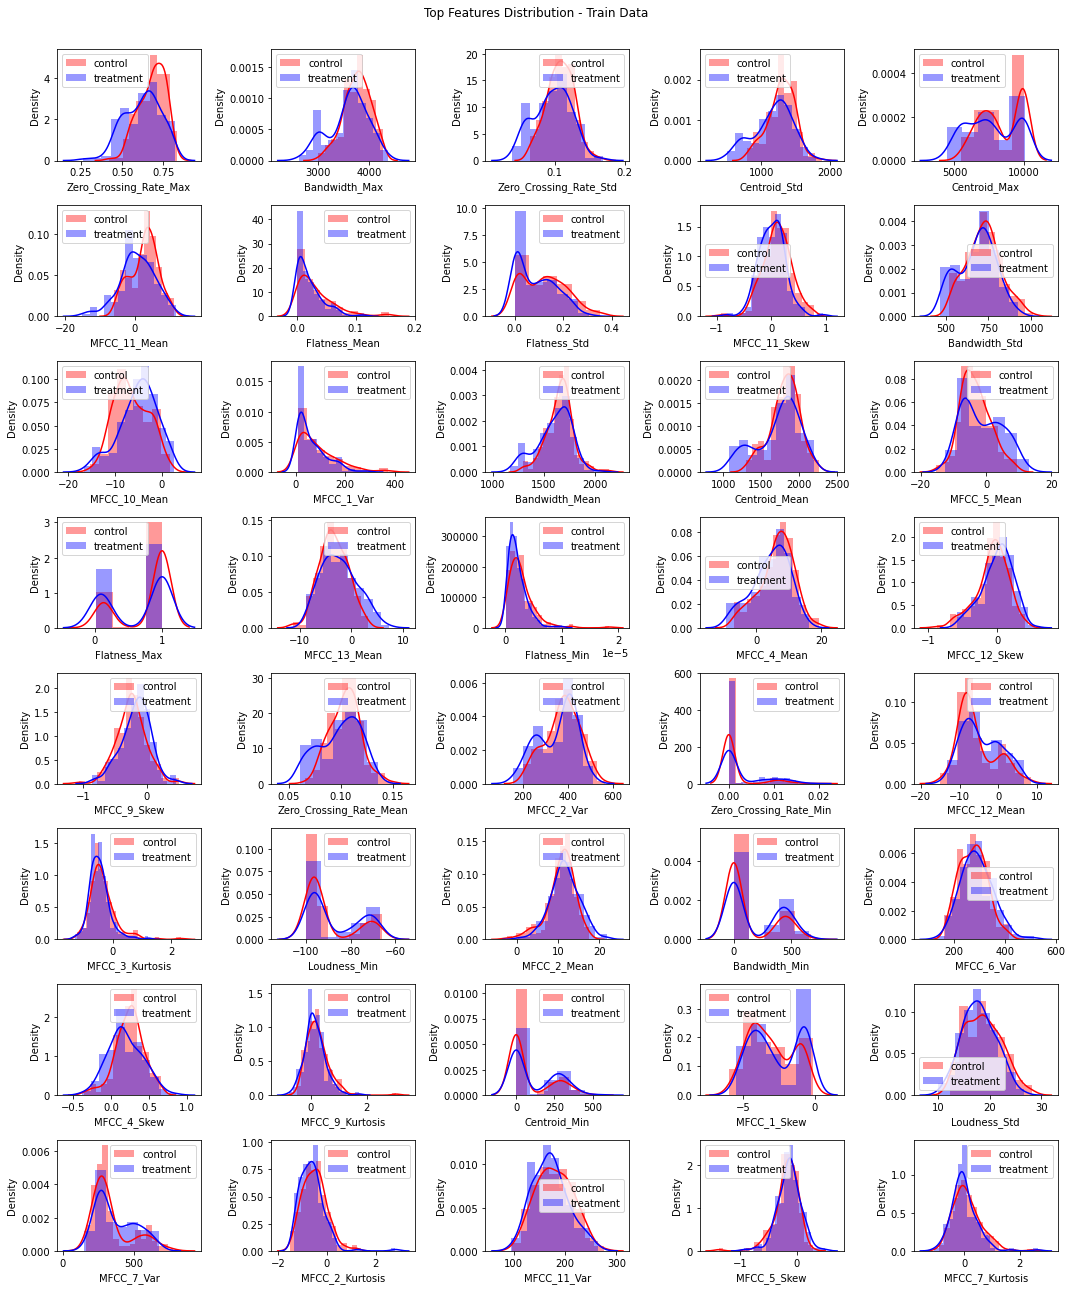

In [43]:
fig = plt.figure(figsize = (15, 20))
j = 0
for i in train.iloc[:,:-2]:
    plt.subplot(9, 5, j+1)
    j += 1
    sns.distplot(train[i][train['mindfulness']==0], color='red', label = 'control')
    sns.distplot(train[i][train['mindfulness']==1], color='blue', label = 'treatment')
    plt.legend(loc='best')
fig.suptitle('Top Features Distribution - Train Data')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

In [44]:
train.to_csv('Train_final.csv', index=False)
test.to_csv('Test_final.csv', index=False)

## Modeling

- run baseline models (no tuning)
- tune models individually 
- compare baseline results with tuned models

In [45]:
train = pd.read_csv('Train_final.csv')
test = pd.read_csv('Test_final.csv')

In [46]:
train.head()

,Zero_Crossing_Rate_Max,Bandwidth_Max,Zero_Crossing_Rate_Std,Centroid_Std,Centroid_Max,MFCC_11_Mean,Flatness_Mean,Flatness_Std,MFCC_11_Skew,Bandwidth_Std,MFCC_10_Mean,MFCC_1_Var,Bandwidth_Mean,Centroid_Mean,MFCC_5_Mean,Flatness_Max,MFCC_13_Mean,Flatness_Min,MFCC_4_Mean,MFCC_12_Skew,MFCC_9_Skew,Zero_Crossing_Rate_Mean,MFCC_2_Var,Zero_Crossing_Rate_Min,MFCC_12_Mean,MFCC_3_Kurtosis,Loudness_Min,MFCC_2_Mean,Bandwidth_Min,MFCC_6_Var,MFCC_4_Skew,MFCC_9_Kurtosis,Centroid_Min,MFCC_1_Skew,Loudness_Std,MFCC_7_Var,MFCC_2_Kurtosis,MFCC_11_Var,MFCC_5_Skew,MFCC_7_Kurtosis,ID,mindfulness
0,0.769531,3884.481590,0.133817,1496.913354,8217.708802,5.493818,0.011037,0.033334,0.173692,762.914777,-4.718021,24.718059,1693.283132,1985.016549,-8.138119,1.000001,-2.476801,0.000004,4.581958,-0.221637,-0.227616,0.124893,475.850023,0.00000,-8.265055,-0.129195,-98.896294,10.825767,0.000000,187.843628,0.256086,-0.014671,0.000000,-4.230216,16.756664,298.939247,-0.850930,156.542377,0.006315,0.551779,303,0
1,0.695801,3569.833665,0.119109,1386.508943,9872.989593,4.596261,0.030171,0.136034,-0.019305,770.322470,-6.261821,79.033239,1685.814144,1957.581191,-2.941836,1.000001,-2.954069,0.000004,7.351410,-0.077089,-0.240000,0.118204,444.204440,0.00000,-7.738903,-0.418319,-96.069733,10.825281,0.000000,227.915375,0.096613,-0.399064,0.000000,-4.279227,18.554764,293.845915,-0.920895,165.867580,-0.021998,0.023170,303,0
2,0.697754,3765.091164,0.105167,1248.127869,9950.074824,6.240943,0.011216,0.065533,0.089565,695.042739,-7.166564,38.719380,1485.367611,1698.109106,-5.753395,1.000001,-2.844933,0.000004,1.046205,-0.054598,-0.318919,0.108241,382.080778,0.00000,-6.439788,-0.306197,-97.227943,16.006744,0.000000,218.019708,0.290532,-0.116459,0.000000,-5.317970,15.457996,326.632389,0.017380,170.018025,-0.115898,0.414822,303,0
3,0.718262,3818.437621,0.098086,1172.476705,7574.198008,5.774253,0.006511,0.018909,0.177557,667.899276,-8.059870,11.141302,1435.782968,1525.731304,-7.073833,0.191774,-4.230279,0.000004,3.927356,0.011918,-0.163995,0.094847,345.704613,0.02002,-8.814217,-0.074201,-79.763451,17.462410,496.565997,286.415136,0.248438,-0.210604,410.076383,-1.255606,14.135759,281.845303,0.254184,181.146991,-0.020926,0.286045,303,0
4,0.665527,3988.385512,0.107320,1262.470204,7622.438967,7.057653,0.029271,0.144011,0.245235,741.905726,-4.356101,87.276340,1516.691729,1735.619811,-6.929995,1.000001,-3.279362,0.000006,0.547571,-0.196021,-0.309849,0.108802,399.951463,0.00000,-8.018169,-0.086344,-100.000000,14.197258,0.000000,236.776652,0.234439,-0.301269,0.000000,-4.221425,17.749538,312.654796,-0.355091,161.101251,0.115011,0.265823,303,0


In [47]:
# feature vectors & target variable

X_train = train.drop(['mindfulness', 'ID'], axis=1)
y_train = train['mindfulness']

X_test = test.drop(['mindfulness', 'ID'], axis=1)
y_test = test['mindfulness']

In [48]:
# check shape

X_train.shape, X_test.shape

((355, 40), (90, 40))

### Baseline Model Comparison

In [130]:
# compare models 
models = []

def classification_models(X_train, y_train):
    
    models.append(('Logistic Regression', LogisticRegression() ))
    models.append( ('SVC',  SVC()) )
    models.append( ('Naive Bayes',  GaussianNB()) )
    models.append( ('KNN', KNeighborsClassifier()) )
    models.append( ('Decision Tree', DecisionTreeClassifier()))
    
    model_names = []
    model_outcomes = []
    
    for name, model in models:
        results = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
        
        model_names.append(name)
        model_outcomes.append(results.mean())
        
        # print(name, results.mean())
        
        model_df = pd.DataFrame(list(zip(model_names, model_outcomes)), columns =['Models', 'Train Accuracy'])
        
    return model_df
        
    # print(model_outcomes)  

In [131]:
train_results = pd.DataFrame()

In [132]:
train_results = classification_models(X_train, y_train)

In [133]:
# return results for each model + training accuracy 
train_results

,Models,Train Accuracy
0,Logistic Regression,0.535211
1,SVC,0.580282
2,Naive Bayes,0.574648
3,KNN,0.552113
4,Decision Tree,0.495775


In [134]:
# evaluation & prediction

def eval_predict_models(X_train, X_test, y_train, y_test):
    
    model_names = []
    model_outcomes = []

    for name, model in models:
        trainedmodel = model.fit(X_train,y_train)
    
        # prediction
        ypredict = trainedmodel.predict(X_test)
    
        acc = accuracy_score(y_test,ypredict)
        classreport = classification_report(y_test,ypredict)
        confMat = confusion_matrix(y_test,ypredict)
        
        model_names.append(name)
        model_outcomes.append(acc) 
        
        print('Model Type: {}'.format(name))
    
        print('The Classification Report:\n {}'.format(classreport))
        print('The Confusion Matrix:\n {}'.format(confMat))
        print('\n************')
    
        model_df = pd.DataFrame((model_names, model_outcomes)).T
        model_df.columns = ['Models', 'Test Accuracy']
    
    return model_df

In [135]:
test_results = pd.DataFrame()

In [136]:
test_results = eval_predict_models(X_train, X_test, y_train, y_test)

Model Type: Logistic Regression
The Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.31      0.34        45
           1       0.42      0.49      0.45        45

    accuracy                           0.40        90
   macro avg       0.40      0.40      0.40        90
weighted avg       0.40      0.40      0.40        90

The Confusion Matrix:
 [[14 31]
 [23 22]]

************
Model Type: SVC
The Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.51      0.50        45
           1       0.49      0.47      0.48        45

    accuracy                           0.49        90
   macro avg       0.49      0.49      0.49        90
weighted avg       0.49      0.49      0.49        90

The Confusion Matrix:
 [[23 22]
 [24 21]]

************
Model Type: Naive Bayes
The Classification Report:
               precision    recall  f1-score   support

           0       0.45

In [137]:
model_results = train_results.merge(test_results, on='Models')
model_results

,Models,Train Accuracy,Test Accuracy
0,Logistic Regression,0.535211,0.4
1,SVC,0.580282,0.488889
2,Naive Bayes,0.574648,0.444444
3,KNN,0.552113,0.444444
4,Decision Tree,0.495775,0.488889


### Hyperparameter Tuning

#### Logistic Regression

In [61]:
logreg = LogisticRegression().fit(X_train, y_train)

In [62]:
logreg_params = {'penalty': ['l1', 'l2', 'none'],
                 'C': [0.001, 0.01, 0.1, 1, 10, 100],
                 'solver': ['liblinear', 'newton-cg']}

logreg_clf = GridSearchCV(estimator=logreg, 
                     param_grid=logreg_params, 
                     cv=5,
                     scoring='accuracy')

logreg_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2', 'none'],
                         'solver': ['liblinear', 'newton-cg']},
             scoring='accuracy')

In [63]:
logreg_clf.best_params_

{'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}

In [64]:
logreg_clf.best_score_

0.5464788732394366

In [65]:
logreg_best = LogisticRegression(penalty='l2', solver='newton-cg', C=0.01).fit(X_train, y_train)

In [66]:
logreg_pred = logreg_best.predict(X_test)
logreg_acc = accuracy_score(y_test, logreg_pred)
logreg_acc

0.4

In [67]:
logreg_pred_train = logreg_best.predict(X_train)
logreg_train_acc = accuracy_score(y_train, logreg_pred_train)
logreg_train_acc

0.6704225352112676

In [68]:
logreg_cv = cross_val_score(logreg_best, X_train, y_train, cv=5, scoring='accuracy').mean()
logreg_cv

0.5464788732394366

The Log Reg model was slightly improved after hyperparameter tuning. Baseline test accuracy was 0.3778 vs tuned model test accuracy is 0.4

In [69]:
logreg_results = ['Logistic Regression', round(logreg_cv, 4), logreg_acc]
logreg_results

['Logistic Regression', 0.5465, 0.4]

#### SVC

In [70]:
svc = SVC().fit(X_train, y_train)

In [71]:
svc_params = {'kernel': ['linear', 'rbf'],
                     'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

svc_clf = GridSearchCV(estimator=svc, 
                     param_grid=svc_params, 
                     cv=5,
                     scoring='accuracy')

svc_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy')

In [72]:
svc_clf.best_params_

{'C': 100, 'kernel': 'rbf'}

In [73]:
svc_clf.best_score_

0.6084507042253521

In [74]:
svc_best = SVC(kernel='rbf', C=100).fit(X_train, y_train)

In [75]:
svc_pred = svc_best.predict(X_test)
svc_acc = accuracy_score(y_test, svc_pred)
svc_acc

0.4

In [76]:
svc_pred_train = svc_best.predict(X_train)
svc_pred_acc = accuracy_score(y_train, svc_pred_train)
svc_pred_acc

0.6281690140845071

In [77]:
svc_cv = cross_val_score(svc_best, X_train, y_train, cv=5, scoring='accuracy').mean()
svc_cv

0.6084507042253521

SVC did not improve after hyperparameter tuning. Baseline test accuracy was 0.4889 vs tuned model test accuracy is 0.4 - keep model's default parameters

In [78]:
svc_pred = svc.predict(X_test)
svc_acc = accuracy_score(y_test, svc_pred)
svc_acc

0.4888888888888889

In [79]:
svc_cv = cross_val_score(svc, X_train, y_train, cv=5, scoring='accuracy').mean()
svc_cv

0.5802816901408451

In [80]:
svc_results = ['SVC', round(svc_cv, 4), round(svc_acc, 4)]
svc_results

['SVC', 0.5803, 0.4889]

#### Gaussian Naive Bayes

In [81]:
gnb = GaussianNB().fit(X_train, y_train)

In [82]:
cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=3, 
                                    random_state=0)

In [83]:
gnb_params = {'var_smoothing': np.logspace(0,-9, num=100)}

gnb_clf = GridSearchCV(estimator=gnb, 
                     param_grid=gnb_params, 
                     cv=cv_method,
                     scoring='accuracy')

Data_transformed = PowerTransformer().fit_transform(X_train)

gnb_clf.fit(Data_transformed, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=0),
             estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.3...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             scoring='accuracy')

In [84]:
gnb_clf.best_params_

{'var_smoothing': 0.12328467394420659}

In [85]:
gnb_clf.best_score_

0.5802816901408451

In [86]:
gnb_best = GaussianNB(var_smoothing=0.12328467394420659).fit(Data_transformed, y_train)

In [89]:
gnb_pred = gnb_best.predict(PowerTransformer().fit_transform(X_test))
gnb_acc = accuracy_score(y_test, gnb_pred)
gnb_acc

0.45555555555555555

In [90]:
gnb_pred_train = gnb_best.predict(Data_transformed)
gnb_pred_acc = accuracy_score(y_train, gnb_pred_train)
gnb_pred_acc

0.5859154929577465

In [91]:
gnb_cv = cross_val_score(gnb_best, Data_transformed, y_train, cv=5, scoring='accuracy').mean()
gnb_cv

0.5718309859154929

After including var_smoothing parameter and power transforming the data, the GNB model's test accuracy didn't really improve compared to the baseline results (0.44)

In [92]:
gnb_results = ['Gaussian Naive Bayes', round(gnb_cv, 4), round(gnb_acc, 4)]
gnb_results

['Gaussian Naive Bayes', 0.5718, 0.4556]

#### KNN 

In [93]:
knn = KNeighborsClassifier().fit(X_train, y_train)

In [94]:
knn_params = {'leaf_size': list(range(1,50)),
              'n_neighbors': list(range(1,20)),
              'p': [1,2],
              'weights': ['uniform', 'distance']}

knn_clf = GridSearchCV(estimator=knn, 
                       param_grid=knn_params, 
                       cv=5,
                       scoring='accuracy')

knn_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19],
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [95]:
knn_clf.best_params_

{'leaf_size': 1, 'n_neighbors': 6, 'p': 2, 'weights': 'distance'}

In [96]:
knn_clf.best_score_

0.5915492957746479

In [97]:
knn_best = KNeighborsClassifier(leaf_size=1, n_neighbors=6, p=2, weights='distance').fit(X_train, y_train)

In [98]:
knn_pred = knn_best.predict(X_test)
knn_acc = accuracy_score(y_test, knn_pred)
knn_acc

0.45555555555555555

In [99]:
knn_pred_train = knn_best.predict(X_train)
knn_pred_acc = accuracy_score(y_train, knn_pred_train)
knn_pred_acc

1.0

In [100]:
knn_cv = cross_val_score(knn_best, X_train, y_trainb, cv=5, scoring='accuracy').mean()
knn_cv

0.5915492957746479

Tuning improves test score (0.45 vs 0.42)

In [101]:
knn_results = ['KNN', round(knn_cv, 4), round(knn_acc, 4)]
knn_results

['KNN', 0.5915, 0.4556]

#### Decision Tree

In [102]:
dtree = DecisionTreeClassifier().fit(X_train, y_train)

In [103]:
# look for optimal ranges of max_depth & max_leaf_nodes to test

for max_d in range(1,21):
  m = DecisionTreeClassifier(max_depth=max_d, random_state=0)
  m.fit(X_train, y_train)
  print('The Training Accuracy for max_depth {} is:'.format(max_d), m.score(X_train, y_train))
  print('The Validation Accuracy for max_depth {} is:'.format(max_d), m.score(X_test, y_test))
  print('')

for max_l in range(10,30):
  m = DecisionTreeClassifier(max_leaf_nodes=max_l, random_state=0)
  m.fit(X_train, y_train)
  print('The Training Accuracy for max_leaf_nodes {} is:'.format(max_l), m.score(X_train, y_train))
  print('The Validation Accuracy for max_leaf_nodes {} is:'.format(max_l), m.score(X_test, y_test))
  print('')

The Training Accuracy for max_depth 1 is: 0.6197183098591549
The Validation Accuracy for max_depth 1 is: 0.4888888888888889

The Training Accuracy for max_depth 2 is: 0.6225352112676056
The Validation Accuracy for max_depth 2 is: 0.45555555555555555

The Training Accuracy for max_depth 3 is: 0.7070422535211267
The Validation Accuracy for max_depth 3 is: 0.4444444444444444

The Training Accuracy for max_depth 4 is: 0.752112676056338
The Validation Accuracy for max_depth 4 is: 0.43333333333333335

The Training Accuracy for max_depth 5 is: 0.7746478873239436
The Validation Accuracy for max_depth 5 is: 0.4777777777777778

The Training Accuracy for max_depth 6 is: 0.828169014084507
The Validation Accuracy for max_depth 6 is: 0.5111111111111111

The Training Accuracy for max_depth 7 is: 0.8845070422535212
The Validation Accuracy for max_depth 7 is: 0.4222222222222222

The Training Accuracy for max_depth 8 is: 0.9408450704225352
The Validation Accuracy for max_depth 8 is: 0.5

The Training Ac

In [118]:
dtree_params = {'max_depth': list(range(5,12)),
              'max_leaf_nodes': list(range(15,26))}

dtree_clf = GridSearchCV(estimator=dtree, 
                       param_grid=dtree_params, 
                       cv=5,
                       scoring='accuracy')

dtree_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [5, 6, 7, 8, 9, 10, 11],
                         'max_leaf_nodes': [15, 16, 17, 18, 19, 20, 21, 22, 23,
                                            24, 25]},
             scoring='accuracy')

In [119]:
dtree_clf.best_params_

{'max_depth': 6, 'max_leaf_nodes': 22}

In [120]:
dtree_clf.best_score_

0.5492957746478873

In [121]:
dtree_best = DecisionTreeClassifier(max_depth=6, max_leaf_nodes=22).fit(X_train, y_train)

In [122]:
dtree_pred = dtree_best.predict(X_test)
dtree_acc = accuracy_score(y_test, dtree_pred)
dtree_acc

0.5111111111111111

In [123]:
dtree_pred_train = dtree_best.predict(X_train)
dtree_pred_acc = accuracy_score(y_train, dtree_pred_train)
dtree_pred_acc

0.828169014084507

In [124]:
dtree_cv = cross_val_score(dtree_best, X_train, y_train, cv=5, scoring='accuracy').mean()
dtree_cv

0.5380281690140845

Improves test accuracy slightly (0.5 vs 0.51) 

In [125]:
dtree_results = ['Decision Tree', round(dtree_cv, 4), round(dtree_acc, 4)]
dtree_results

['Decision Tree', 0.538, 0.5111]

#### Final Model Comparison 

In [126]:
final_model_results = pd.DataFrame([logreg_results, svc_results, gnb_results, knn_results, dtree_results])
final_model_results.columns = ['Model', 'Train Accuracy', 'Test Accuracy']
final_model_results

,Model,Train Accuracy,Test Accuracy
0,Logistic Regression,0.5465,0.4000
1,SVC,0.5803,0.4889
2,Gaussian Naive Bayes,0.5718,0.4556
3,KNN,0.5915,0.4556
4,Decision Tree,0.5380,0.5111


In [138]:
# compare to baseline model results

round(model_results, 4)

,Models,Train Accuracy,Test Accuracy
0,Logistic Regression,0.5352,0.4
1,SVC,0.5803,0.488889
2,Naive Bayes,0.5746,0.444444
3,KNN,0.5521,0.444444
4,Decision Tree,0.4958,0.488889


Decision Tree had the most improvement in test accuracy after hyperparameter tuning (0.467 vs 0.511), while the other models didn't really improve in performance. Overall the models still have a fairly weak performance in classifying treatment/control groups, even after the chunking process.

#### Classification Report & Confusion Matrix

In [139]:
# Decision Tree

dtree_classreport = classification_report(y_test, dtree_pred)
dtree_confMat = confusion_matrix(y_test, dtree_pred)

In [141]:
print('Decision Tree')
print(dtree_classreport)
print(dtree_confMat)

Decision Tree
              precision    recall  f1-score   support

           0       0.51      0.49      0.50        45
           1       0.51      0.53      0.52        45

    accuracy                           0.51        90
   macro avg       0.51      0.51      0.51        90
weighted avg       0.51      0.51      0.51        90

[[22 23]
 [21 24]]
